In [111]:
import nltk
import re
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from nltk.collocations import *
from collections import defaultdict

# Asociacion de palabras

## 1 - Reading and parsing corpus (xml parser failed, so did it manually)

In [13]:
with open('ap/ap.txt', 'r') as f:
    corpus = f.read()
corpus = corpus.split('\n')

lines_per_doc = 6
documents = {}
for i in range(0, len(corpus)//lines_per_doc):
    doc_number = corpus[i*lines_per_doc + 1].replace('<DOCNO> ','').replace(' </DOCNO>','')
    documents[doc_number] = corpus[i*lines_per_doc + 3]

## 2 - Vocabulary size

In [40]:
vocabulary = defaultdict(int)
tokenized_documents = []
for document in documents.values():
    words = nltk.word_tokenize(document)
    tokenized_document = []
    for word in words:
        if re.match('[a-zA-Z]', word) == None:
            # Remove symbols
            continue
        vocabulary[word] += 1
        tokenized_document.append(word)
    tokenized_documents.append(tokenized_document)

print('Vocabulary size: {}'.format(len(vocabulary)))

Vocabulary size: 42110


## 3 - Associations

In [42]:
more_frequent_words = sorted(vocabulary.items(), key=lambda i: i[1], reverse=True)[:500]
more_frequent_words = [item[0] for item in more_frequent_words]

In [43]:
full_corpus = []
window_size = 6
# Join documents with joiner in between so it doesnt associate words between documents
joiner = ['xxxx'] * window_size
for document in tokenized_documents:
    full_corpus += document
    full_corpus += joiner

In [56]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(full_corpus, window_size=window_size)
scored = finder.score_ngrams(bigram_measures.pmi)

# Just keep the pair in which both words are included in the 500 more frequent words
for pair, _ in scored:
    if pair[0] in more_frequent_words and pair[1] in more_frequent_words:
        print('Most associated pair: {}'.format(pair))
        break

Most associated pair: ('Communist', 'Party')


# Informacion Lexica

## 1 - Load and smart tokenize

In [187]:
with open('pg2009.txt', 'r') as f:
    book = f.read()
book = nltk.word_tokenize(book)
book = [word.lower() for word in book if re.match('[a-zA-Z]', word) != None]

## 2 - Distribution of word over book

In [77]:
words_to_test = ['plants', 'instinct', 'for']
word_indexes = [[i for i, x in enumerate(book) if x == word] for word in words_to_test]

from math import pi, sqrt, e
def gaussian(x, sigma=50):
    return (e**(-((x**2)/(2*(sigma**2)))))/(sqrt(2*pi)*sigma)

In [113]:
probabilities = [[],[],[]]
for position, _ in tqdm(enumerate(book)):
    for i, _ in enumerate(words_to_test):
        probability = 0
        for index in word_indexes[i]:
            probability += gaussian(position - index)
        probabilities[i].append(probability)

typical_domain_size = 20000

# for p(t + tau) not to give me a out of index exception
for i, _ in enumerate(probabilities):
    probabilities[i] += [0] * typical_domain_size

210468it [13:42, 255.86it/s]


In [114]:
autocorrelations = []
for i, word in enumerate(words_to_test):
    autoc = []
    average_prob = np.average(probabilities[i])
    divisor = np.average([p**2 for p in probabilities[i]]) - (average_prob**2)
    for tau in tqdm(range(0,typical_domain_size)):
        first = np.average([probabilities[i][j]*probabilities[i][j+tau] for j in range(len(book))])
        second = average_prob*np.average([probabilities[i][j+tau] for j in range(len(book))])
        autoc.append((first-second)/divisor)
    autocorrelations.append(autoc)

100%|██████████| 20000/20000 [59:46<00:00,  5.54it/s]


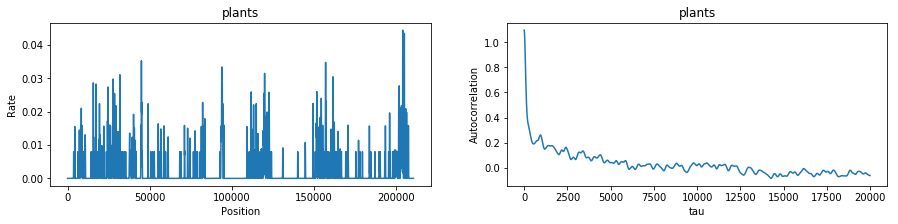

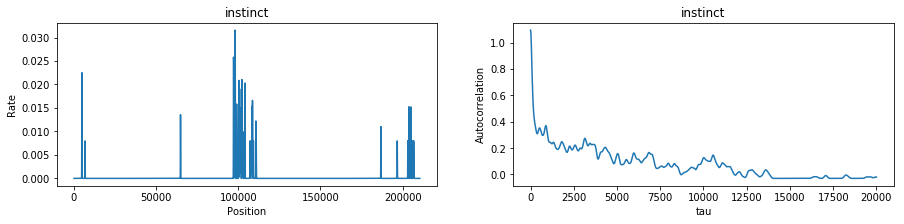

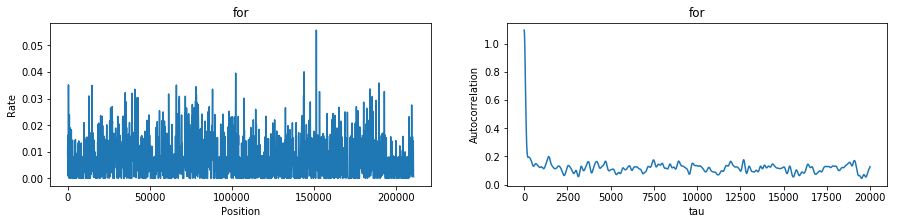

In [123]:
plt.rcParams["figure.figsize"] = (15, 3)
for i, word in enumerate(words_to_test):
    plt.subplot(1, 2, 1)
    plt.plot(range(len(book)), probabilities[i][:len(book)])
    plt.xlabel("Position")
    plt.ylabel("Rate")
    plt.title(word)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(len(autocorrelations[i])), autocorrelations[i])
    plt.xlabel("tau")
    plt.ylabel("Autocorrelation")
    plt.title(word)
    plt.show()

## 3 - Entropy sorted

In [173]:
all_count = defaultdict(int)
all_words = set(book)

for word in book:
    all_count[word] += 1

number_of_parts = 128

def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))
    
selected_words = []

counts = defaultdict(list)
for word, count in all_count.items():
    counts[count] = word

sorted_counts = sorted(counts.items(), key=lambda x: x[0], reverse=True)
for p in split(sorted_counts, 99):
    selected_words.append(p[0][1])
# This is because im choosing the first one of each part, so the last one wouldnt be included
selected_words.append(sorted_counts[-1][1])

In [174]:
parts = list(split(book, number_of_parts))

In [175]:
#all_count = {key: value for (key, value) in all_count.items() if key in selected_words}
inpart_count = []

for part in parts:
    counts = defaultdict(int)
    for word in part:
        counts[word] += 1
    #counts = {key: value for (key, value) in counts.items() if key in selected_words}
    inpart_count.append(counts)

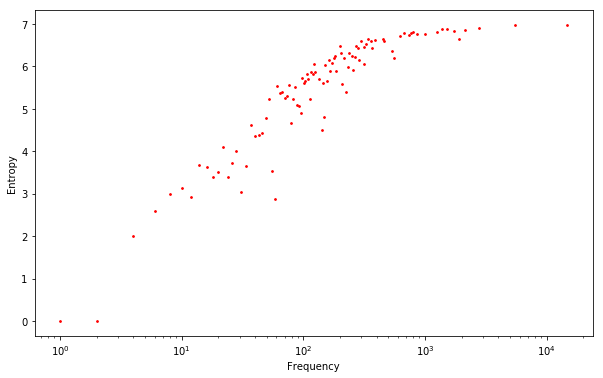

In [184]:
plt.rcParams["figure.figsize"] = (10, 6)
entropy_sorted_text = {}
from math import log2

for word in selected_words:
    values = [(inpart_count[i][word]/all_count[word])*log2(inpart_count[i][word]/all_count[word]) for i, _ in enumerate(parts) if word in inpart_count[i]]
    entropy_sorted_text[word] = -sum(values)

plt.scatter([all_count[word] for word in selected_words], [entropy_sorted_text[word] for word in selected_words], 3, 'red')
plt.xlabel("Frequency")
plt.ylabel("Entropy")
plt.xscale("log", nonposx='clip')
plt.show()

## 4 - Entropy Shuffle

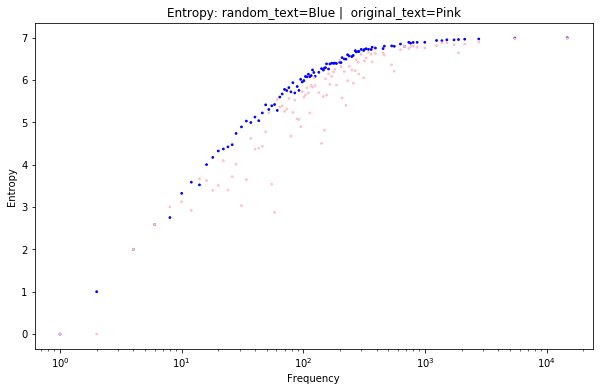

In [195]:
import random
shuffled_book = list(book)
random.shuffle(shuffled_book)

parts_shuffle = list(split(shuffled_book, number_of_parts))

shuffle_inpart_count = []

for part in parts_shuffle:
    counts = defaultdict(int)
    for word in part:
        counts[word] += 1
    #counts = {key: value for (key, value) in counts.items() if key in selected_words}
    shuffle_inpart_count.append(counts)

plt.rcParams["figure.figsize"] = (10, 6)
entropy_shuffled_text = {}
from math import log2

for word in selected_words:
    values = [(shuffle_inpart_count[i][word]/all_count[word])*log2(shuffle_inpart_count[i][word]/all_count[word]) for i, _ in enumerate(parts) if word in shuffle_inpart_count[i]]
    entropy_shuffled_text[word] = -sum(values)

xs = [all_count[word] for word in selected_words]*2
ys = [entropy_shuffled_text[word] for word in selected_words]+[entropy_sorted_text[word] for word in selected_words]
colors = (['blue']*len(selected_words))+(['pink']*len(selected_words))
plt.scatter(xs, ys, 3, colors)
plt.title('Entropy: random_text=Blue |  original_text=Pink')
plt.xlabel("Frequency")
plt.ylabel("Entropy")
plt.xscale("log", nonposx='clip')
plt.show()

Lo que se puede ver es muy logico. En el caso del texto original, se puede ver que las palabras tienen una entropia mas variada dentro del mismo rango de frecuencia, esto sucede porque las palabras, al estar distribuidas a lo largo del texto con un sentido especifico (dependiendo el capitulo y tematica especifica y compartida de cada particion) agregan una cantidad de informacion real y significativa. Mientras que en el caso del texto randomizado, todas las palabras van a aparecer distribuidas uniformemente en todo el texto (en mayor densidad o menor, depende la frecuencia de la misma) entonces no estan agregando una cantidad de informacion importante, si una palabra aparece con una distribucion uniforme tiene sentido que sea redundante su información.

Por supuesto cuanto menos frecuente sean las palabras en el texto, menor entropia van a tener porque mayor informacion estarian dando (ya que son poco usuales), por eso tiene esa tendencia el grafico.

Por otro lado, siempre, no importa la frecuencia, hay ciertas palabras que tienen una entropia alta con respecto al resto de las palabras en esa frecuencia, estas deben ser palabras que tienen un uso especifico en el lenguaje, y por lo tanto no agregan informacion especifica, sino que tienen un rol mas sintactico que semantico.

# Word embeddings, distancia semantica y Word-Net

Uso corpus de gutenberg y webtext, gutemberg porque era recomendado por nltk y webtext porque me parece bueno tener algunos documentos que no sean especificamente academicos y formales.

## 1

In [213]:
from nltk.corpus import webtext
from gensim import corpora, models, similarities

original_sents = nltk.corpus.webtext.sents() + nltk.corpus.gutenberg.sents()

dictionary = corpora.Dictionary(original_sents)

corpus = [dictionary.doc2bow(text) for text in original_sents]
corpora.MmCorpus.serialize('corpus.mm', corpus)
corpus = corpora.MmCorpus('corpus.mm')

lsi = models.LsiModel(corpus, id2word=dictionary)
w2v = models.Word2Vec(original_sents)

Leo el test wordsim353

In [228]:
words = []
ws353_test = []
with open('ws353simrel/wordsim353_agreed.txt', 'r') as ws353:
    for line in ws353:
        if line[0] == '#':
            continue
        ln = line.split('\t')[1:]
        ws353_test.append(float(ln[-1].strip()))
        words.append((ln[0], ln[1]))

Calculo similaridades. Para LSA calculo los vectores de cada palabra y mido el coseno del angulo que forman

In [271]:
lsa_similarity = []
w2v_similarity = []
ws_test = []
for i, (word1, word2) in enumerate(words):
    try:
        w2v_similarity.append(w2v.wv.similarity(word1, word2))
    except KeyError:
        continue
    lsa_similarity.append(gensim.matutils.cossim(lsi[dictionary.doc2bow([word1])], lsi[dictionary.doc2bow([word2])]))
    ws_test.append(ws353_test[i])

Uso el coeficiente de correlacion de spearman para ambos resultados contra el de test 353, como medida de rendimiento.
Para graficar normalizo usando la informacion que se sobre cada modelo (lsa devuelve un numero de -1 a 1 y w2v devuelve uno de 0 a 1)

Spearman correlation:
LSA: SpearmanrResult(correlation=0.29094568907520391, pvalue=1.2660952362233813e-05)
W2V: SpearmanrResult(correlation=0.16341035191095118, pvalue=0.015730451890219259)


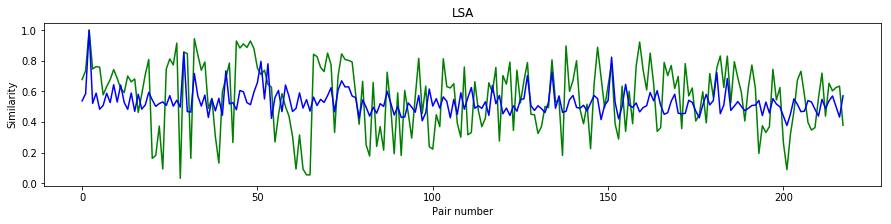

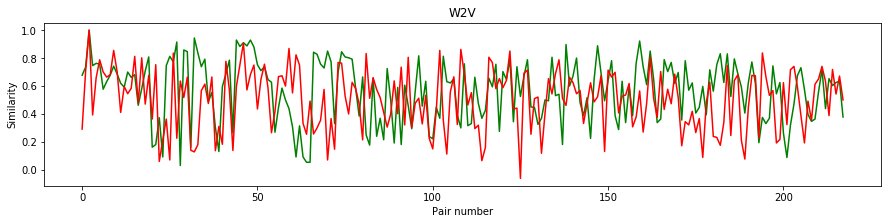

In [260]:
from scipy.stats import spearmanr
print('Spearman correlation:')
print('LSA: {}'.format(spearmanr(ws_test, lsa_similarity)))
print('W2V: {}'.format(spearmanr(ws_test, w2v_similarity)))

plt.rcParams["figure.figsize"] = (15, 3)
plt.plot(range(len(ws_test)), [e/10 for e in ws_test], 'g')
plt.plot(range(len(lsa_similarity)), [(1 + e) / 2 for e in lsa_similarity], 'b')
plt.xlabel("Pair number")
plt.ylabel("Similarity")
plt.title('LSA')
plt.show()

plt.plot(range(len(ws_test)), [e/10 for e in ws_test], 'g')
plt.plot(range(len(w2v_similarity)), w2v_similarity, 'r')
plt.xlabel("Pair number")
plt.ylabel("Similarity")
plt.title('W2V')
plt.show()

Se puede ver que LSA muestra una correlacion significativa con el test de wordsim con un p-valor bajo. Pero w2v nos dio cierta correlacion pero poco confiable.
Capaz se necesita un corpus mas grande?

## 2

In [272]:
from nltk.corpus import wordnet

lch_similarity = []
path_similarity = []
wup_similarity = []

lsa_similarity_wn = []
w2v_similarity_wn = []

ws_test_wn = []

for i, (word1, word2) in enumerate(words):
    try:
        w2v_s = w2v.wv.similarity(word1, word2)
    
        lsa_s = gensim.matutils.cossim(lsi[dictionary.doc2bow([word1])], lsi[dictionary.doc2bow([word2])])

        w1 = wordnet.synsets(word1)
        w2 = wordnet.synsets(word2)
        #try:
        lch_s = w1[0].lch_similarity(w2[0])
        path_s = w1[0].path_similarity(w2[0])
        wup_s = w1[0].wup_similarity(w2[0])
        #except Exception:
        #    continue
        lch_similarity.append(lch_s)
        path_similarity.append(path_s)
        wup_similarity.append(wup_s)

        lsa_similarity_wn.append(lsa_s)
        w2v_similarity_wn.append(w2v_s)

        ws_test_wn.append(ws353_test[i])
    # Errores raros
    except Exception:
        continue
        
amount = len(ws_test_wn)

LSA
Spearman correlation:
LCH: SpearmanrResult(correlation=0.11471678369134104, pvalue=0.09261556874106569)
PATH: SpearmanrResult(correlation=0.11471678369134104, pvalue=0.09261556874106569)
WUP: SpearmanrResult(correlation=0.13370736995472265, pvalue=0.049703439321464066)


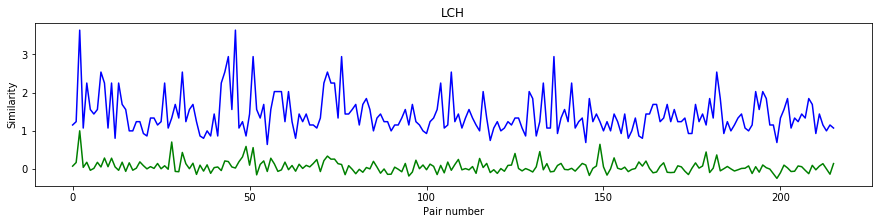

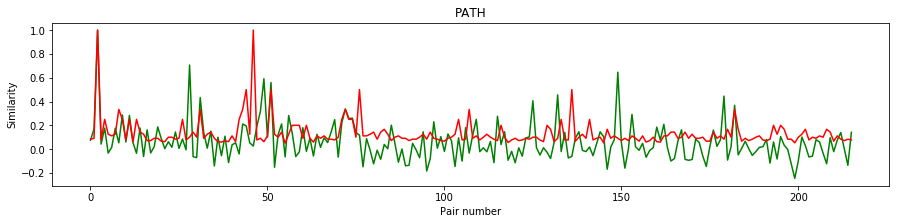

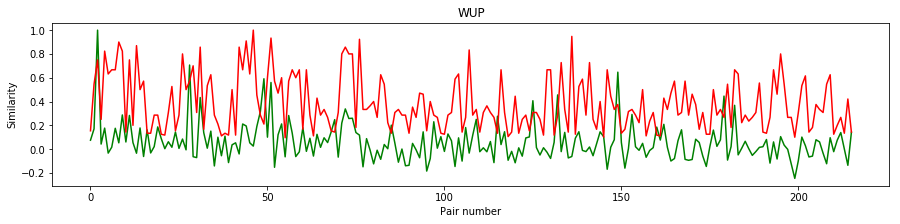

In [273]:
print('LSA')
print('Spearman correlation:')
print('LCH: {}'.format(spearmanr(lch_similarity, lsa_similarity_wn)))
print('PATH: {}'.format(spearmanr(path_similarity, lsa_similarity_wn)))
print('WUP: {}'.format(spearmanr(wup_similarity, lsa_similarity_wn)))

plt.rcParams["figure.figsize"] = (15, 3)
plt.plot(range(amount), lsa_similarity_wn, 'g')
plt.plot(range(amount), lch_similarity, 'b')
plt.xlabel("Pair number")
plt.ylabel("Similarity")
plt.title('LCH')
plt.show()

plt.plot(range(amount), lsa_similarity_wn, 'g')
plt.plot(range(amount), path_similarity, 'r')
plt.xlabel("Pair number")
plt.ylabel("Similarity")
plt.title('PATH')
plt.show()

plt.plot(range(amount), lsa_similarity_wn, 'g')
plt.plot(range(amount), wup_similarity, 'r')
plt.xlabel("Pair number")
plt.ylabel("Similarity")
plt.title('WUP')
plt.show()

W2V
Spearman correlation:
LCH: SpearmanrResult(correlation=0.13292170857980384, pvalue=0.051072273106302787)
PATH: SpearmanrResult(correlation=0.13292170857980384, pvalue=0.051072273106302787)
WUP: SpearmanrResult(correlation=0.21953963075193667, pvalue=0.001164033909541099)


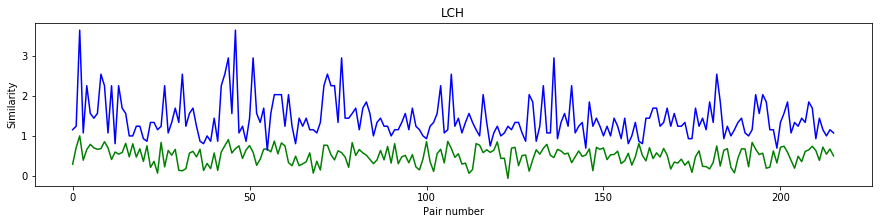

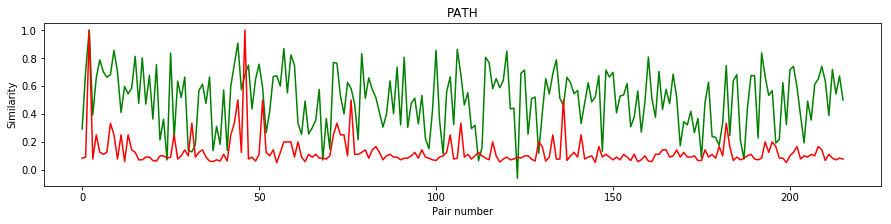

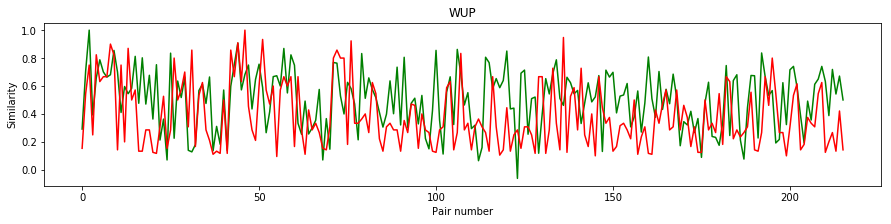

In [274]:
print('W2V')
print('Spearman correlation:')
print('LCH: {}'.format(spearmanr(lch_similarity, w2v_similarity_wn)))
print('PATH: {}'.format(spearmanr(path_similarity, w2v_similarity_wn)))
print('WUP: {}'.format(spearmanr(wup_similarity, w2v_similarity_wn)))

plt.rcParams["figure.figsize"] = (15, 3)
plt.plot(range(amount), w2v_similarity_wn, 'g')
plt.plot(range(amount), lch_similarity, 'b')
plt.xlabel("Pair number")
plt.ylabel("Similarity")
plt.title('LCH')
plt.show()

plt.plot(range(amount), w2v_similarity_wn, 'g')
plt.plot(range(amount), path_similarity, 'r')
plt.xlabel("Pair number")
plt.ylabel("Similarity")
plt.title('PATH')
plt.show()

plt.plot(range(amount), w2v_similarity_wn, 'g')
plt.plot(range(amount), wup_similarity, 'r')
plt.xlabel("Pair number")
plt.ylabel("Similarity")
plt.title('WUP')
plt.show()

Nuevamente, hay correlacion pero el pvalor no me da mucha confianza sobre el coeficiente. Y mirando los graficos me da la misma sensacion, se ven ciertos picos compartidos pero no es mu confiable.